In [1]:
!pip install retina-face

In [2]:
pip install tensorflow opencv-python mtcnn scikit-learn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00


In [3]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=9d523a7252f93a2223b099c87e0c9f09989ba55566a8ea0b37ce953b47a8c12b
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [9]:
import os
import cv2
from retinaface import RetinaFace

# Input image path
img_path = "/content/img2.jpeg"

# Output directory to save detected faces
output_folder = "/content/input_faces"
os.makedirs(output_folder, exist_ok=True)

# Load image
img = cv2.imread(img_path)

# Detect faces
faces = RetinaFace.detect_faces(img_path)

# Process each detected face
for i, key in enumerate(faces.keys()):
    identity = faces[key]
    facial_area = identity["facial_area"]

    # Crop the face
    x1, y1, x2, y2 = facial_area
    face_crop = img[y1:y2, x1:x2]

    # Save the cropped face
    face_filename = os.path.join(output_folder, f"face_{i+1}.jpg")
    cv2.imwrite(face_filename, face_crop)
    print(f"✅ Saved: {face_filename}")

print(f"✅ All detected faces are saved in {output_folder}")


✅ Saved: /content/input_faces/face_1.jpg
✅ Saved: /content/input_faces/face_2.jpg
✅ Saved: /content/input_faces/face_3.jpg
✅ All detected faces are saved in /content/input_faces


In [10]:
import os
import numpy as np
from deepface import DeepFace
import cv2

# Define folder paths
IMAGE_FOLDER = "/content/input_faces"  # Change to your folder path
EMBEDDINGS_PATH = "/content/embeddings/face_embeddings.npz"

# Ensure output directory exists
os.makedirs(os.path.dirname(EMBEDDINGS_PATH), exist_ok=True)

def process_images(image_folder):
    embeddings = {}

    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        person_name = os.path.splitext(filename)[0]
        image_path = os.path.join(image_folder, filename)

        try:
            # Extract embedding
            embedding = DeepFace.represent(img_path=image_path, model_name="Facenet", enforce_detection=False)[0]['embedding']
            embeddings[person_name] = embedding
            print(f"✅ Processed: {filename}")
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")

    # Save embeddings
    np.savez_compressed(EMBEDDINGS_PATH, **embeddings)
    print(f"✅ Embeddings saved at {EMBEDDINGS_PATH}")

    return embeddings

# Run processing
embeddings = process_images(IMAGE_FOLDER)

✅ Processed: face_3.jpg
✅ Processed: face_1.jpg
✅ Processed: face_2.jpg
✅ Embeddings saved at /content/embeddings/face_embeddings.npz


In [ ]:
!ls

embeddings  img4.JPG  input_faces  kirtiraj_10.jpg  sample_data


# New section

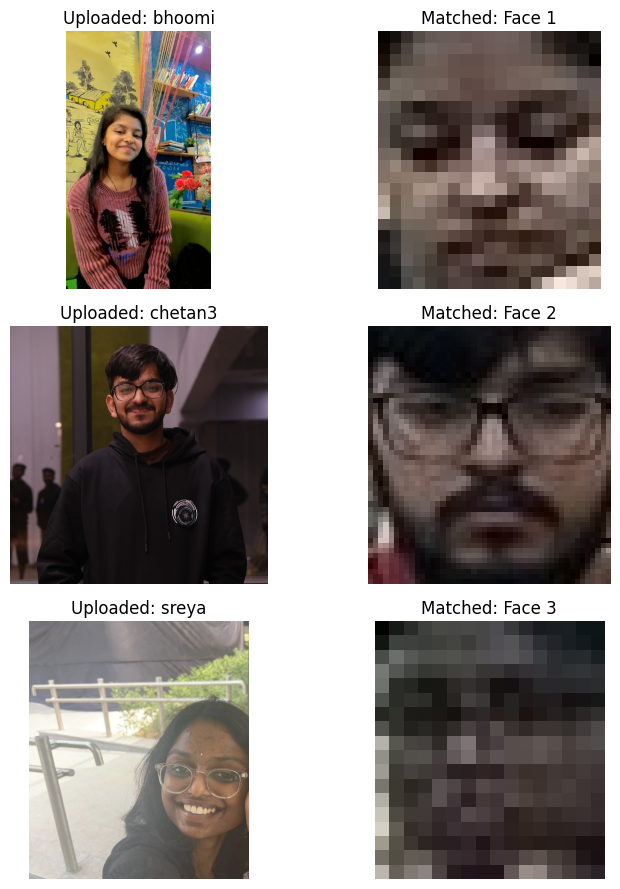

In [8]:
import os
import numpy as np
from deepface import DeepFace
from scipy.spatial.distance import cosine
import cv2
import matplotlib.pyplot as plt

# Define paths
EMBEDDINGS_PATH = "/content/embeddings/face_embeddings.npz"  # Path to stored embeddings
IMAGES_DIR = "/content/input_faces"  # Directory containing individual images
FOLDER_INPUT_IMAGES = "/content/faces"  # Folder of images to match against the database

# ✅ Step 1: Load stored embeddings
if not os.path.exists(EMBEDDINGS_PATH):
    raise FileNotFoundError(f"❌ Embeddings file not found at {EMBEDDINGS_PATH}")

data = np.load(EMBEDDINGS_PATH)
embeddings_dict = {name: data[name] for name in data.files}

# ✅ Step 2: Function to process and extract embedding for an image
def extract_embedding(image_path):
    try:
        return DeepFace.represent(img_path=image_path, model_name="Facenet", enforce_detection=False)[0]['embedding']
    except Exception as e:
        print(f"❌ Failed to extract embedding from {image_path}: {e}")
        return None

# ✅ Step 3: Function to compute similarity score
def compute_similarity(input_embedding, embeddings_dict):
    scores = {}
    for person, stored_embedding in embeddings_dict.items():
        similarity = 1 - cosine(input_embedding, stored_embedding)
        scores[person] = similarity
    return scores

# ✅ Step 4: Process each image in the folder and find best match
def process_images(input_folder):
    results = []  # To store results for all images
    for image_name in sorted(os.listdir(input_folder)):
        image_path = os.path.join(input_folder, image_name)

        if os.path.isfile(image_path):
            # Extract the embedding for the input image
            input_embedding = extract_embedding(image_path)

            if input_embedding is not None:
                # Compute similarity with stored embeddings
                scores = compute_similarity(input_embedding, embeddings_dict)

                # Find the best match
                best_match = max(scores, key=scores.get)
                best_score = scores[best_match]

                # Get matched image path
                matched_image_path = os.path.join(IMAGES_DIR, f"{best_match}.jpg")  # Assuming images are named after the person

                # Check if the matched image exists
                if os.path.exists(matched_image_path):
                    matched_image = cv2.imread(matched_image_path)
                else:
                    matched_image = None

                # Append results
                results.append({
                    'uploaded': os.path.basename(image_path).split('.')[0],
                    'input_image': image_path,
                    'best_match': best_match,
                    'best_score': best_score,
                    'matched_image': matched_image
                })
    return results

# ✅ Step 5: Create custom output visualization
def display_results(results):
    # Calculate number of rows needed
    num_rows = len(results)

    # Set up a figure for displaying results
    fig, axes = plt.subplots(num_rows, 2, figsize=(8, num_rows * 3))

    if num_rows == 1:
        axes = [axes]  # Ensure axes is a 2D array for consistency

    for i, result in enumerate(results):
        # Display input image
        input_image = cv2.imread(result['input_image'])
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        # Display matched image
        if result['matched_image'] is not None:
            matched_image = cv2.cvtColor(result['matched_image'], cv2.COLOR_BGR2RGB)
        else:
            matched_image = np.zeros_like(input_image)  # Blank image if no match

        # Left column: Uploaded image with label
        axes[i][0].imshow(input_image)
        axes[i][0].axis("off")
        axes[i][0].set_title(f"Uploaded: {result['uploaded']}")

        # Right column: Matched image with label
        axes[i][1].imshow(matched_image)
        axes[i][1].axis("off")
        axes[i][1].set_title(f"Matched: Face {i+1}")

    plt.tight_layout()
    plt.show()

# ✅ Step 6: Run the process
results = process_images(FOLDER_INPUT_IMAGES)
if results:
    display_results(results)
else:
    print("No images were processed.")


🔍 *Similarity Scores:*
face_3: 0.2131
face_1: 0.2197
face_2: 0.1276

🎯 Best Match: face_1 with similarity score 0.2197


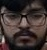

In [1]:
import os
import numpy as np
from deepface import DeepFace
from scipy.spatial.distance import cosine
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow

# Define paths
EMBEDDINGS_PATH = "/content/embeddings/face_embeddings.npz"  # Path to stored embeddings
INPUT_IMAGE = "/content/chetan3.jpg"  # Change to the test image path
IMAGES_DIR = "/content/input_faces"  # Directory containing individual images

# ✅ Step 1: Load stored embeddings
if not os.path.exists(EMBEDDINGS_PATH):
    raise FileNotFoundError(f"❌ Embeddings file not found at {EMBEDDINGS_PATH}")

data = np.load(EMBEDDINGS_PATH)
embeddings_dict = {name: data[name] for name in data.files}

# ✅ Step 2: Extract embedding of input image
try:
    input_embedding = DeepFace.represent(img_path=INPUT_IMAGE, model_name="Facenet", enforce_detection=False)[0]['embedding']
except Exception as e:
    raise RuntimeError(f"❌ Failed to extract embedding from input image: {e}")

# ✅ Step 3: Compute similarity scores
scores = {}

for person, stored_embedding in embeddings_dict.items():
    similarity = 1 - cosine(input_embedding, stored_embedding)
    scores[person] = similarity

# ✅ Step 4: Find the best match
best_match = max(scores, key=scores.get)
best_score = scores[best_match]

# ✅ Step 5: Display results
print("\n🔍 *Similarity Scores:*")
for person, score in scores.items():
    print(f"{person}: {score:.4f}")

print(f"\n🎯 Best Match: {best_match} with similarity score {best_score:.4f}")

# ✅ Step 6: Display the image of the matched person
matched_image_path = os.path.join(IMAGES_DIR, f"{best_match}.jpg")  # Assuming images are named after the person
if os.path.exists(matched_image_path):
    matched_image = cv2.imread(matched_image_path)
    if matched_image is not None:
        cv2_imshow(matched_image)  # Use cv2_imshow instead of cv2.imshow
    else:
        print(f"❌ Failed to read the image for {best_match}.")
else:
    print(f"❌ Image for {best_match} not found at {matched_image_path}.")


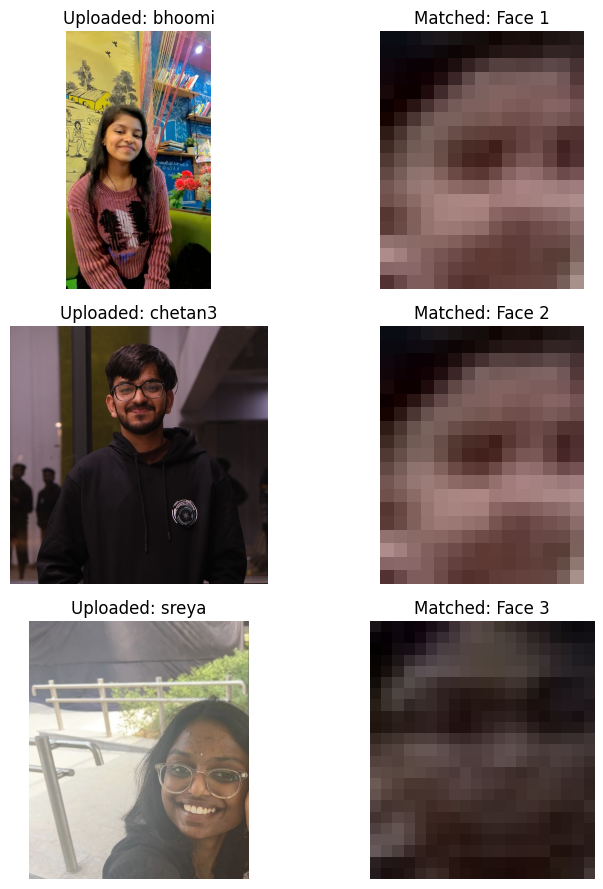

In [11]:
import os
import numpy as np
from deepface import DeepFace
from scipy.spatial.distance import cosine
import cv2
import matplotlib.pyplot as plt

# Define paths
EMBEDDINGS_PATH = "/content/embeddings/face_embeddings.npz"  # Path to stored embeddings
IMAGES_DIR = "/content/input_faces"  # Directory containing individual images
FOLDER_INPUT_IMAGES = "/content/faces"  # Folder of images to match against the database

# ✅ Step 1: Load stored embeddings
if not os.path.exists(EMBEDDINGS_PATH):
    raise FileNotFoundError(f"❌ Embeddings file not found at {EMBEDDINGS_PATH}")

data = np.load(EMBEDDINGS_PATH)
embeddings_dict = {name: data[name] for name in data.files}

# ✅ Step 2: Function to process and extract embedding for an image
def extract_embedding(image_path):
    try:
        return DeepFace.represent(img_path=image_path, model_name="Facenet", enforce_detection=False)[0]['embedding']
    except Exception as e:
        print(f"❌ Failed to extract embedding from {image_path}: {e}")
        return None

# ✅ Step 3: Function to compute similarity score
def compute_similarity(input_embedding, embeddings_dict):
    scores = {}
    for person, stored_embedding in embeddings_dict.items():
        similarity = 1 - cosine(input_embedding, stored_embedding)
        scores[person] = similarity
    return scores

# ✅ Step 4: Process each image in the folder and find best match
def process_images(input_folder):
    results = []  # To store results for all images
    for image_name in sorted(os.listdir(input_folder)):
        image_path = os.path.join(input_folder, image_name)

        if os.path.isfile(image_path):
            # Extract the embedding for the input image
            input_embedding = extract_embedding(image_path)

            if input_embedding is not None:
                # Compute similarity with stored embeddings
                scores = compute_similarity(input_embedding, embeddings_dict)

                # Find the best match
                best_match = max(scores, key=scores.get)
                best_score = scores[best_match]

                # Get matched image path
                matched_image_path = os.path.join(IMAGES_DIR, f"{best_match}.jpg")  # Assuming images are named after the person

                # Check if the matched image exists
                if os.path.exists(matched_image_path):
                    matched_image = cv2.imread(matched_image_path)
                else:
                    matched_image = None

                # Append results
                results.append({
                    'uploaded': os.path.basename(image_path).split('.')[0],
                    'input_image': image_path,
                    'best_match': best_match,
                    'best_score': best_score,
                    'matched_image': matched_image
                })
    return results

# ✅ Step 5: Create custom output visualization
def display_results(results):
    # Calculate number of rows needed
    num_rows = len(results)

    # Set up a figure for displaying results
    fig, axes = plt.subplots(num_rows, 2, figsize=(8, num_rows * 3))

    if num_rows == 1:
        axes = [axes]  # Ensure axes is a 2D array for consistency

    for i, result in enumerate(results):
        # Display input image
        input_image = cv2.imread(result['input_image'])
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        # Display matched image
        if result['matched_image'] is not None:
            matched_image = cv2.cvtColor(result['matched_image'], cv2.COLOR_BGR2RGB)
        else:
            matched_image = np.zeros_like(input_image)  # Blank image if no match

        # Left column: Uploaded image with label
        axes[i][0].imshow(input_image)
        axes[i][0].axis("off")
        axes[i][0].set_title(f"Uploaded: {result['uploaded']}")

        # Right column: Matched image with label
        axes[i][1].imshow(matched_image)
        axes[i][1].axis("off")
        axes[i][1].set_title(f"Matched: Face {i+1}")

    plt.tight_layout()
    plt.show()

# ✅ Step 6: Run the process
results = process_images(FOLDER_INPUT_IMAGES)
if results:
    display_results(results)
else:
    print("No images were processed.")